# HBURS, project 3
by Alessandro G. Magnasco

In [1]:
## System imports

# system library
import os

# math & data operations libraries
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pylab import rcParams # for feature density plotting

# machine learning libraries
import mglearn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay # sklearn v.1.1
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import silhouette_score
#from kneed import KneeLocator # automatic elbow locator, for future implementation

# charting libraries
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, ward

# python errors and warnings for debug
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126378 entries, 0 to 126377
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   BBL            126378 non-null  int64  
 1   OfficialViols  250 non-null     float64
 2   AEP            250 non-null     float64
 3   RepairCount    44128 non-null   float64
 4   RepairCost     44128 non-null   float64
 5   ClassB_count   110092 non-null  float64
 6   ClassB         110092 non-null  float64
 7   ClassC_count   77014 non-null   float64
 8   ClassC         77014 non-null   float64
 9   SumViols       126378 non-null  float64
 10  ViolsDiff      250 non-null     float64
dtypes: float64(10), int64(1)
memory usage: 10.6 MB


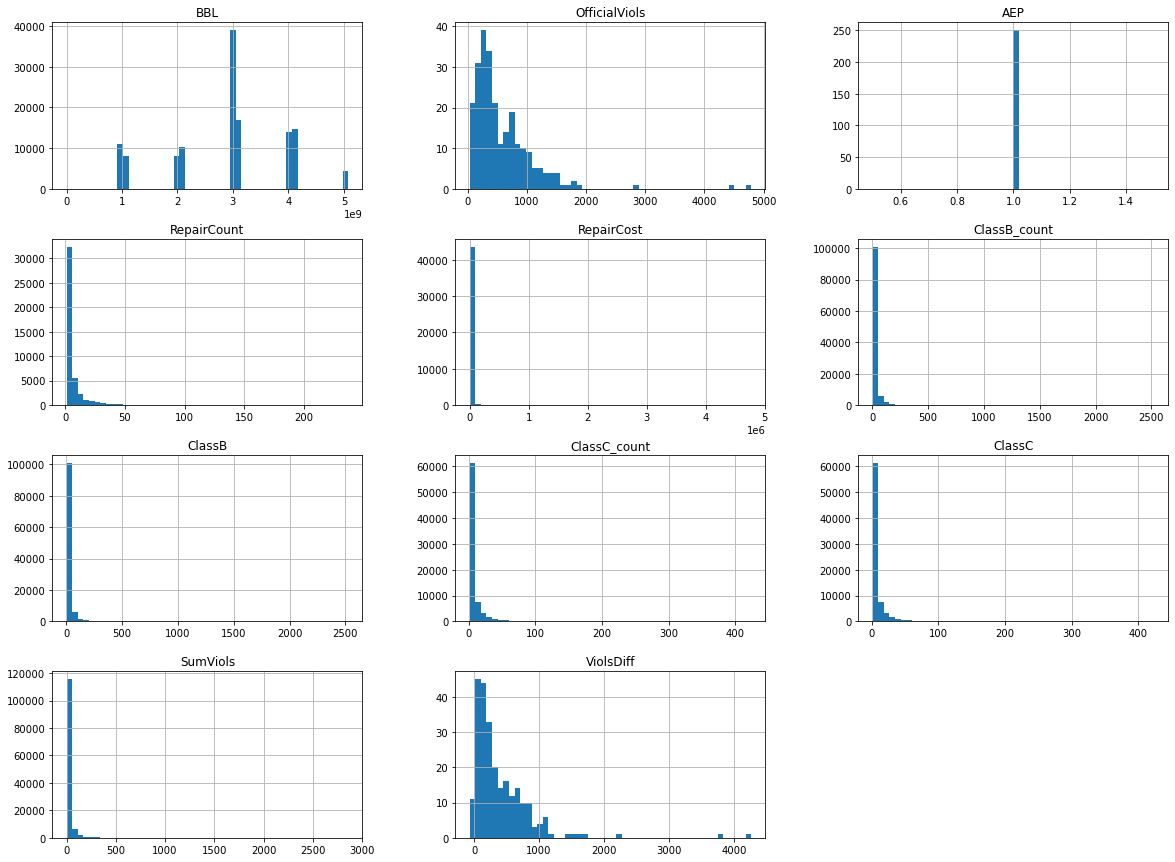

In [2]:
# Step 3.0 - import
bg=0
def import_cleaned_data():
    global bg
    bg = pd.read_csv(r'''bg.csv''', low_memory=False)

import_cleaned_data()
bg.info()

bg.hist(bins=50, figsize=(20,15)) # 20,15
plt.show()

In [3]:
# Step 3.1 - cleaning & split into training/testing

print('Count before dropping NAs: \n',bg.count())
# drop any row that contains any NA value in the parameter columns
bg_dn = bg.dropna(axis=0,how='any', subset=['RepairCost','ClassB','ClassC','RepairCount'])
print('\n\nCount after dropping NAs: \n',bg_dn.count())
# filling remaining NA values with 0
bg_n = bg_dn.fillna(axis=0,value=0)
print(bg_n.head(2000))

Count before dropping NAs: 
 BBL              126378
OfficialViols       250
AEP                 250
RepairCount       44128
RepairCost        44128
ClassB_count     110092
ClassB           110092
ClassC_count      77014
ClassC            77014
SumViols         126378
ViolsDiff           250
dtype: int64


Count after dropping NAs: 
 BBL              32986
OfficialViols      248
AEP                248
RepairCount      32986
RepairCost       32986
ClassB_count     32986
ClassB           32986
ClassC_count     32986
ClassC           32986
SumViols         32986
ViolsDiff          248
dtype: int64
             BBL  OfficialViols  AEP  RepairCount  RepairCost  ClassB_count  \
0     1002050018          186.0  1.0          6.0     6017.00          67.0   
1     1002390011          169.0  1.0          7.0     2286.00          68.0   
3     1003090021          238.0  1.0          4.0     8722.00          75.0   
4     1003100024          108.0  1.0         14.0   105142.37          37.0   
5  

In [4]:
## preparing data, split into features and target

# creating data and target sets using the full dataset
data_un = bg_n[['RepairCost','ClassB','ClassC','RepairCount']] # selecting features
target_un = bg_n['AEP'].astype('int8') # this was already established as a dummy

# fitting the scaler
scaler = StandardScaler()
scaler.fit(data_un)

# creating data and target sets using the scaled dataset
data_sc = scaler.transform(data_un)
target_sc = target_un

In [5]:
# stratified shuffle split
split = StratifiedShuffleSplit(
    n_splits=1, # still not clear on how to set this value appropriately
    test_size=0.2, # 20% testing and 80% training 
    random_state=4 # RNGs always spit out "4" for me anyway so might as well
)

## SCALED DATA
# using iloc on target to match the RNG index to the BBL index
for train_index, test_index in split.split(data_sc, target_sc):
    X_train_sc = data_sc[train_index]
    X_test_sc = data_sc[test_index]
    y_train_sc = target_sc.iloc[train_index]
    y_test_sc = target_sc.iloc[test_index]

## NON-SCALED DATA
# using iloc to match the RNG index to the BBL index
for train_index, test_index in split.split(data_un, target_un):
    X_train_un = data_un.iloc[train_index]
    X_test_un = data_un.iloc[test_index]
    y_train_un_d = target_un.iloc[train_index]
    y_test_un_d = target_un.iloc[test_index]

# converting target sets into 1D arrays
y_train_un = y_train_un_d.values.ravel()
y_test_un = y_test_un_d.values.ravel()

In [6]:
# Step 3.2: PCA for feature selection

# here we will apply a dimensionality reduction
pca95 = PCA(
    #n_components = 0.95 # this will select the smallest number of features that add up to 95% of the variance
    n_components=3 # manually using 3 dimensions because it gets us close enough, otherwise would use all 4 dim.
     )

# fitting this simplified Principal Component Analysis to the scaled data
pca95.fit(X_train_sc)

ev = pca95.explained_variance_ratio_

print("A variance of",round(sum(ev*100),2),"% can be explained by",np.size(ev),
      "of the",X_train_sc.shape[1],"dimensions (we had already removed most)."
     )
print("\nThese are the ratios:\n",
      #pd.Series(ev,index=X_train_sc.columns) # need to figure out how to match these properly
      ev
     )

A variance of 94.94 % can be explained by 3 of the 4 dimensions (we had already removed most).

These are the ratios:
 [0.59538394 0.25007278 0.10396522]


Text(0, 0.5, 'Principal components')

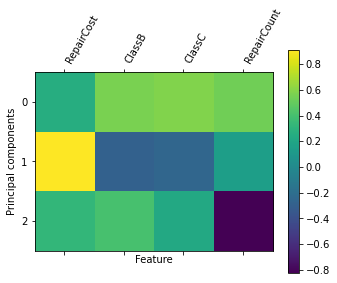

In [7]:
# plotting the principal components

plt.matshow(pca95.components_, cmap='viridis')
plt.colorbar()
plt.xticks(range(len(X_train_un.columns)),
           X_train_un.columns, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

# question: how can we be sure that the columns are mapped properly to the features?

In [8]:
# testing on a Decision Tree classifier

# UNSCALED DATA
print('UNSCALED DATA')
tree_un = DecisionTreeClassifier(random_state=0).fit(X_train_un, y_train_un)
print("Accuracy on training set: {:.2f}".format(tree_un.score(X_train_un, y_train_un)))
print("Accuracy on test set: {:.2f}".format(tree_un.score(X_test_un, y_test_un)))

# SCALED DATA
print('SCALED DATA')
tree_sc = DecisionTreeClassifier(random_state=0).fit(X_train_sc, y_train_sc)
print("Accuracy on training set: {:.2f}".format(tree_sc.score(X_train_sc, y_train_sc)))
print("Accuracy on test set: {:.2f}".format(tree_sc.score(X_test_sc, y_test_sc)))

# I might have done something wrong here.

UNSCALED DATA
Accuracy on training set: 1.00
Accuracy on test set: 0.99
SCALED DATA
Accuracy on training set: 1.00
Accuracy on test set: 0.99


## Step 3.3: Applying three kinds of clustering

In [9]:
# Creating a random cluster for comparison
# using the UNSCALED dataset.

random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train_un))

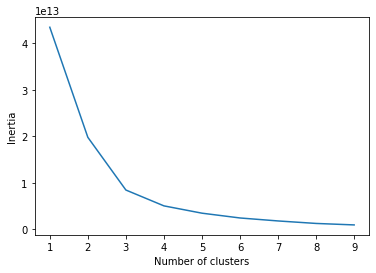

In [10]:
# using an elbow visualization to determine the optimal number of clusters
# using the UNSCALED dataset.

inertiaVals_un = {}

for k in range(1, 10):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000).fit(X_train_un)
    inertiaVals_un[k] = kmeansTmp.inertia_ 

plt.figure()
plt.plot(list(inertiaVals_un.keys()), list(inertiaVals_un.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [11]:
# using an automatic elbow locator
# using the UNSCALED dataset.

# FOR FUTURE IMPLEMENTATION.

#i = np.arange(len(inertiaVals_un.values()))
#elbow_un = KneeLocator(i,inertiaVals_un.values(),S=1,curve='convex',direction='decreasing',interp_method='polynomial')

#fig = plt.figure(figsize=(5,5))
#plt.xlabel("Points")
#plt.ylabel("Distance")

#print(distances[knee.knee])

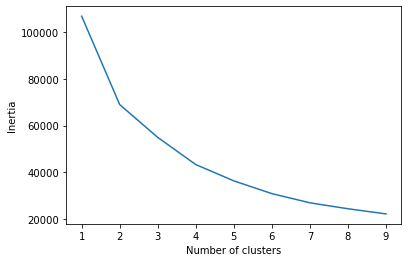

In [12]:
# using an elbow visualization to determine the optimal number of clusters
# using the SCALED dataset.

inertiaVals_sc = {}

for k in range(1, 10):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000).fit(X_train_sc)
    inertiaVals_sc[k] = kmeansTmp.inertia_ 

plt.figure()
plt.plot(list(inertiaVals_sc.keys()), list(inertiaVals_sc.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

### Step 3.3.1: k-means

In [13]:
## k-means without PCA

# building and fitting the clustering model
kmeans_un = KMeans(n_clusters=3) # the optimal we found with the elbow above
kmeans_un.fit_predict(X_train_un)
kmeans_un_pred = kmeans_un.labels_ # the resulting predictions

Text(0, 0.5, 'Feature 1')

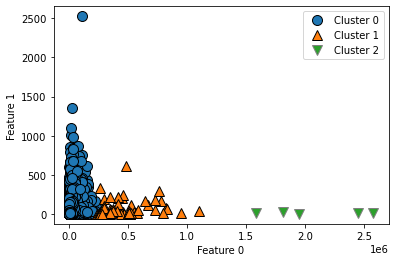

In [14]:
# visualizing k-means without PCA
# using a scatterplot from the mglearn book
mglearn.discrete_scatter(X_train_un.iloc[:, 0], X_train_un.iloc[:, 1], kmeans_un_pred) # had to add iloc as scatter assumed array
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [15]:
# ARI for k-means without PCA
print('ARI for k-means without PCA:',round(adjusted_rand_score(y_train_un, kmeans_un_pred),3))

ARI for k-means without PCA: -0.004


In [16]:
# silhouette coefficient for k-means without PCA
print('Silhouette for k-means without PCA:',round(silhouette_score(X_train_un, kmeans_un_pred),3))

Silhouette for k-means without PCA: 0.977


In [17]:
# k-means with PCA

# building and fitting the clustering model
kmeans_sc = KMeans(n_clusters=4) # the optimal we found with the elbow above
kmeans_sc.fit_predict(X_train_sc) # might need to add values method to remove labels
kmeans_sc_pred = kmeans_sc.labels_ # the resulting predictions

Text(0, 0.5, 'Feature 1')

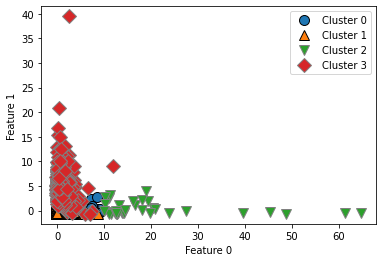

In [18]:
# visualizing k-means with PCA
# using a scatterplot from the mglearn book
mglearn.discrete_scatter(X_train_sc[:, 0], X_train_sc[:, 1], kmeans_sc_pred)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [19]:
# ARI for k-means with PCA
print('ARI for k-means with PCA:',round(adjusted_rand_score(y_train_sc, kmeans_sc_pred),3))

ARI for k-means with PCA: 0.049


In [20]:
# silhouette coefficient for k-means with PCA
print('Silhouette for k-means with PCA:',round(silhouette_score(X_train_sc, kmeans_sc_pred),3))

Silhouette for k-means with PCA: 0.629


### Step 3.3.2: agglomerate/hierarchical

In [21]:
# agglomerate without PCA

# building and fitting the clustering model
agg_un = AgglomerativeClustering(n_clusters=3) # using the optimal number of clusters determined through elbow plot
agg_un.fit_predict(X_train_un)
agg_un_pred = agg_un.labels_

Text(0, 0.5, 'Feature 1')

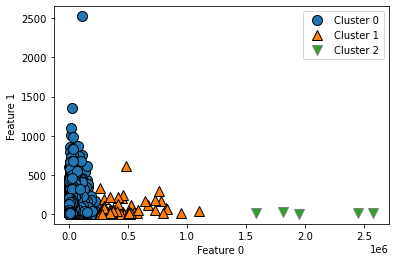

In [22]:
# visualizing 
mglearn.discrete_scatter(X_train_un.iloc[:, 0], X_train_un.iloc[:, 1], agg_un_pred)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Cluster distance')

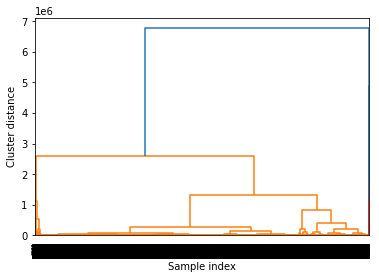

In [23]:
# dendogram visualization

# making an array of ward cluster distances between agglomerations
# using the UNSCALED dataset.
linkage_array_un = ward(X_train_un)
# plotting a dendogram of the ward distances
dendrogram(linkage_array_un)

plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

In [24]:
# ARI for agglomerate without PCA
print('ARI for agglomerate without PCA:',round(adjusted_rand_score(y_train_un, agg_un_pred),3))

ARI for agglomerate without PCA: -0.004


In [25]:
# silhouette coefficient for agglomerate without PCA
print('Silhouette for agglomerate without PCA:',round(silhouette_score(X_train_sc, agg_un_pred),3))

Silhouette for agglomerate without PCA: 0.877


In [26]:
# agglomerate with PCA

# building and fitting the clustering model
agg_sc = AgglomerativeClustering(n_clusters=4) # using the optimal number of clusters determined through elbow plot
agg_sc.fit_predict(X_train_sc)
agg_sc_pred = agg_sc.labels_

Text(0, 0.5, 'Feature 1')

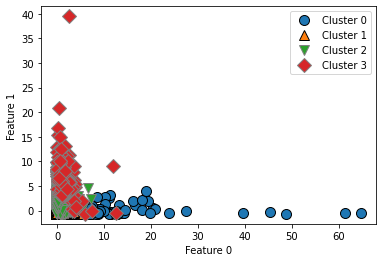

In [27]:
# visualizing 
mglearn.discrete_scatter(X_train_sc[:, 0], X_train_sc[:, 1], agg_sc_pred)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Cluster distance')

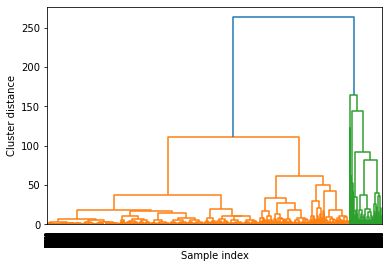

In [28]:
# dendogram visualization

# making an array of ward cluster distances between agglomerations
# using the SCALED dataset.
linkage_array_sc = ward(X_train_sc)
# plotting a dendogram of the ward distances
dendrogram(linkage_array_sc)

plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

In [29]:
# ARI for agglomerate with PCA
print('ARI for agglomerate with PCA:',round(adjusted_rand_score(y_train_sc, agg_sc_pred),3))

ARI for agglomerate with PCA: 0.056


In [30]:
# silhouette coefficient for agglomerate with PCA
print('Silhouette for agglomerate with PCA:',round(silhouette_score(X_train_sc, agg_sc_pred),3))

Silhouette for agglomerate with PCA: 0.689


### Step 3.3.3: DBSCAN

In [31]:
# optimal parameters for DBSCAN
# from https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

db_samples = 2*len(X_train_un.columns) # twice the number of dimensions
print('Optimal Samples:',db_samples)

Optimal Samples: 8


In [32]:
# DBSCAN without PCA

# building and fitting the clustering model
dbscan_un = DBSCAN(min_samples=8,eps=3, metric='cityblock') # epsilon determined from elbow plot, Manhattan distance
dbscan_un.fit_predict(X_train_un)
dbscan_un_pred = dbscan_un.labels_

Text(0, 0.5, 'Feature 1')

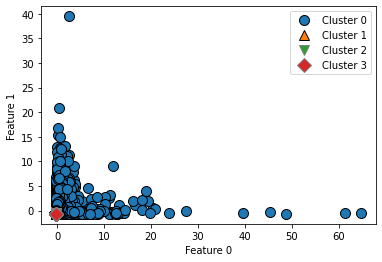

In [33]:
# visualizing 
mglearn.discrete_scatter(X_train_sc[:, 0], X_train_sc[:, 1], dbscan_un_pred)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [34]:
# ARI for DBSCAN without PCA
print('ARI for k-means without PCA:',round(adjusted_rand_score(y_train_un, dbscan_un_pred),3))

ARI for k-means without PCA: -0.013


In [35]:
# silhouette coefficient for DBSCAN without PCA
print('Silhouette for k-means without PCA:',round(silhouette_score(X_train_sc, dbscan_un_pred),3))

Silhouette for k-means without PCA: -0.521


In [38]:
# DBSCAN with PCA

# building and fitting the clustering model
dbscan_sc = DBSCAN(min_samples=8,eps=4) # epsilon determined from elbow plot
dbscan_sc.fit_predict(X_train_sc)
dbscan_sc_pred = dbscan_sc.labels_

Text(0, 0.5, 'Feature 1')

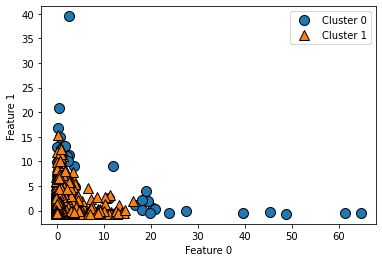

In [39]:
# visualizing
mglearn.discrete_scatter(X_train_sc[:, 0], X_train_sc[:, 1], dbscan_sc_pred)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [40]:
# ARI for DBSCAN with PCA
print('ARI for k-means without PCA:',round(adjusted_rand_score(y_train_un, dbscan_sc_pred),3))

ARI for k-means without PCA: -0.002


In [41]:
# silhouette coefficient for DBSCAN with PCA
print('Silhouette for k-means without PCA:',round(silhouette_score(X_train_sc, dbscan_sc_pred),3))

Silhouette for k-means without PCA: 0.936
